In [1]:
import numpy as np
import pandas as pd

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_data = pd.read_csv('input/train.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
n_train = len(train_data)
n_pixels = len(train_data.columns) - 1
n_class = len(set(train_data['label']))

In [7]:
print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [8]:
test_data = pd.read_csv('input/test.csv')

n_test = len(test_data)
n_pixels = len(test_data.columns)

In [9]:
print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


C:\Users\usr\Anaconda3\envs\Py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


4, 2, 9, 9, 9, 3, 4, 8


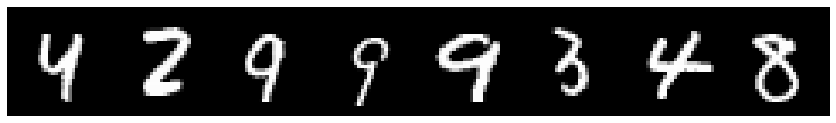

In [10]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_data.iloc[random_sel, 1:].as_matrix()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_data.iloc[random_sel, 0].values), sep = ', ')

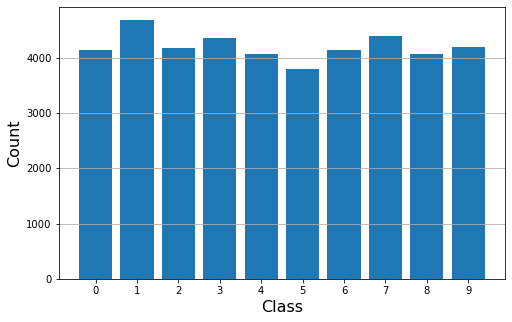

In [11]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_data['label'].value_counts().index, train_data['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

In [12]:
num, px = np.array(train_data).shape
height = width = int(np.sqrt(px-1))
num, px, height, width

(42000, 785, 28, 28)

In [13]:
img_min = np.array(train_data).min()
img_max = np.array(train_data).max()
img_min, img_max

(0, 255)

In [14]:
img_norm_mean = np.array(train_data, dtype=float).mean() / img_max
img_norm_mean

0.13087070313475707

In [15]:
img_std = np.sqrt(np.sum((np.array(train_data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
img_std

0.3085670315794816

In [16]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(img_norm_mean,), std=(img_std,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [17]:
train_dataset = MNIST_data('input/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                             transforms.ToTensor(), 
                             transforms.Normalize(mean=(img_norm_mean,), std=(img_std,))]))

test_dataset = MNIST_data('input/test.csv')

In [18]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                          shuffle=False)

In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5,
                               padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)
        
        #fully connected layers
        ## convert matrix with 8*5*5 (= 200) features to a matrix of 120 features (columns)
        self.fc1 = nn.Linear(in_features=8*5*5,
                             out_features=120) 
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84, 
                             out_features=10)

    def forward(self, x):
        
        # convolve, then perform ReLU non-linearity
        # max-pooling with 2x2 grid 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # flattening convolutional layer
        x = x.view(-1, 8 * 5 * 5)
        
        # fully-connected layers + perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

In [36]:
model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
torch.manual_seed(123)

In [38]:
epochs = 20
log_interval = 1000
iterations = len(train_loader.dataset)//batch_size

In [39]:
print("training set size                ", len(train_loader.dataset))
print("validation set size              ", len(test_loader.dataset))
print("batch size (training/validation) ", batch_size)
print("iterations in epoch              ", iterations)

training set size                 42000
validation set size               28000
batch size (training/validation)  8
iterations in epoch               5250


In [40]:
%%time

for epoch in range(epochs): # entire dataset is passed forward and backward through the nn
    model.train()
    
    epoch_training_loss = 0
    print("=== epoch %2d ===" % (epoch + 1))
    
    for batch_idx, training_batch in enumerate(train_loader, 0):        
        inputs, labels = training_batch[0].to(device), training_batch[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        
        #backward propagation
        loss.backward()
        
        # Update the parameters(weight,bias)
        optimizer.step()
        
        epoch_training_loss += loss.item()# .data
        if batch_idx % 1000 == 999:    
            print('Epoch %d, step %5d loss: %.3f' %
                  (epoch + 1, batch_idx + 1, epoch_training_loss / 1000))
            epoch_training_loss = 0.0


=== epoch  1 ===
Epoch 1, step  1000 loss: 2.292
Epoch 1, step  2000 loss: 2.255
Epoch 1, step  3000 loss: 2.068
Epoch 1, step  4000 loss: 1.111
Epoch 1, step  5000 loss: 0.631
=== epoch  2 ===
Epoch 2, step  1000 loss: 0.480
Epoch 2, step  2000 loss: 0.423
Epoch 2, step  3000 loss: 0.375
Epoch 2, step  4000 loss: 0.353
Epoch 2, step  5000 loss: 0.325
=== epoch  3 ===
Epoch 3, step  1000 loss: 0.291
Epoch 3, step  2000 loss: 0.279
Epoch 3, step  3000 loss: 0.255
Epoch 3, step  4000 loss: 0.250
Epoch 3, step  5000 loss: 0.222
=== epoch  4 ===
Epoch 4, step  1000 loss: 0.208
Epoch 4, step  2000 loss: 0.202
Epoch 4, step  3000 loss: 0.186
Epoch 4, step  4000 loss: 0.181
Epoch 4, step  5000 loss: 0.184
=== epoch  5 ===
Epoch 5, step  1000 loss: 0.165
Epoch 5, step  2000 loss: 0.149
Epoch 5, step  3000 loss: 0.162
Epoch 5, step  4000 loss: 0.154
Epoch 5, step  5000 loss: 0.140
=== epoch  6 ===
Epoch 6, step  1000 loss: 0.134
Epoch 6, step  2000 loss: 0.125
Epoch 6, step  3000 loss: 0.131
Ep

In [41]:
model.eval()
test_pred = torch.LongTensor()
test_pred = test_pred.to(device)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)

In [42]:
test_pred 

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]], device='cuda:0')

In [43]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.cpu().numpy()], 
                      columns=['ImageId', 'Label'])

In [44]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [45]:
out_df.to_csv('submission_LeNet5.csv', index=False)

![wtf](images\submissions.jpg)